In [67]:
import os
import csv
import pandas as pd
import numpy as np
import sklearn
import string
import statsmodels.api as sm
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from nltk import tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [5]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

### Read in Data

In [6]:
# Read in Data
data = pd.read_csv('./input/hash_house.csv')
data['userid'] = data['Unnamed: 0']
data.head()

,Unnamed: 0,name,stars_y,text,userid
0,0,Hash House A Go Go,5,"Firstly, this restaurant is in The Linq Hotel,...",0
1,1,Hash House A Go Go,4,This place had monsterous proportions OMG! One...,1
2,2,Hash House A Go Go,5,This place freaking rocks. Must go to when in ...,2
3,3,Hash House A Go Go,3,Visited HHAGG ago go for the first time on 5/5...,3
4,4,Hash House A Go Go,3,Big portions. Sharing is highly recommended. H...,4


In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/jasper/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Number of Topics

In [8]:
# Split reviews into individual sentences 
df = pd.DataFrame(columns=['userid','sentence','stars'])
for i in range(0,len(data),1):
    sentences = tokenize.sent_tokenize(data.text[i])
    for j in sentences:
        df = df.append({'userid':data.userid[i],'sentence':j,'stars':data.stars_y[i]},ignore_index=True)

In [9]:
df.head()

,userid,sentence,stars
0,0,"Firstly, this restaurant is in The Linq Hotel,...",5
1,0,Expect a line.,5
2,0,"Waited only about 15 minutes to be seated, tho...",5
3,0,Greeted by Tony our waiter who was really warm...,5
4,0,Ordered the Sage Fried Chicken and Waffles.,5


In [10]:
# Create Corpus for TFIDF
corpus = []
for i in df.sentence:
        corpus.append(i)

### 7 Topics

In [11]:
n_components = 7
n_top_words = 15

# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus)

# NMF reduction
nmf = NMF(n_components=n_components).fit(tfidf)
W_pos = nmf.fit_transform(tfidf)

# Output Topics
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: great service friendly excellent experience staff customer slow server fast atmosphere attentive waiter quick bad
Topic #1: chicken waffles fried sage benedict ordered bacon got eggs delicious andy waffle potatoes crispy hash
Topic #2: huge portions large big share portion delicious people prices plate massive enormous hungry meal tasty
Topic #3: good really pretty service overall just potatoes biscuits bloody thing mary taste coffee biscuit wasn
Topic #4: place vegas breakfast definitely hash love house try time come eat best recommend just las
Topic #5: food amazing delicious man vs awesome just came lot price excellent took quality tasty large
Topic #6: wait worth long time minutes hour seated 30 table minute 45 20 come definitely 10



- Topic #0: Service
- Topic #1: Food
- Topic #2: "Worth it"
- Topic #3: Food / Service
- Topic #4: 
- Topic #5: Food
- Topic #6: Wait

### Label Sentences

In [12]:
# Append Topic with highest score
array = []
# For all NMF array
for i in range(0,len(W_pos),1):
    # Create dictionary with Topics and its NMF scores for each sentence
    topic_dict = {}
    # Drop sentences that have length less than 10 by setting topic to -1
    if len(corpus[i])>=10:
        for ind, w in enumerate(W_pos[i]):
            topic_dict[ind] = w
        # Classify sentence to the topic with highest score
        array.append(max(topic_dict, key=topic_dict.get))
    else:
        array.append(-1)
# Create new column in df for topic
df['Topic'] = array

In [13]:
df.head()

,userid,sentence,stars,Topic
0,0,"Firstly, this restaurant is in The Linq Hotel,...",5,4
1,0,Expect a line.,5,6
2,0,"Waited only about 15 minutes to be seated, tho...",5,6
3,0,Greeted by Tony our waiter who was really warm...,5,3
4,0,Ordered the Sage Fried Chicken and Waffles.,5,1


### Vader Sentiment Analysis

In [14]:
# Initialize Sentiment Intensity Analyzer
analyser = SentimentIntensityAnalyzer()

In [15]:
# Append Sentiment Intensity Scores for each sentence
array = []
for i in df.sentence:
    # Generate Sentiment Intensity Scores and store in array
    score = analyser.polarity_scores(i)
    array.append(score['compound'])
# Create new column in df for sentiment intensity score
df['sentiment'] = array

In [16]:
df.head()

,userid,sentence,stars,Topic,sentiment
0,0,"Firstly, this restaurant is in The Linq Hotel,...",5,4,0.0000
1,0,Expect a line.,5,6,0.0000
2,0,"Waited only about 15 minutes to be seated, tho...",5,6,0.0000
3,0,Greeted by Tony our waiter who was really warm...,5,3,0.8669
4,0,Ordered the Sage Fried Chicken and Waffles.,5,1,0.0000


In [17]:
# Initialize Final df of intensity scores
df_scores = pd.DataFrame(columns=['userid','topic_0','topic_1','topic_2',
                                  'topic_3','topic_4','topic_5','topic_6','stars'])
# For every user aggregate the sentiment scores by topic
for i in range(0,len(data),1):
    # Create df of scores from same user
    temp_df = df[df.userid==i].reset_index(drop=True)
    # For every topic
    topic_score = []
    for j in range(0,7,1):
        score = 0
        count = 0
        for k in range(0,len(temp_df),1):
            # If topic equal to current topic
            if temp_df.Topic[k] == j:
                # Add sentiment score
                score = score + temp_df.sentiment[k]
                # Increase count
                count = count + 1
        # If count = 0 then no score for topic
        if count==0:
            topic_score.append(0)
        # Else append average score for topic
        else:
            topic_score.append(score/count)
    # Insert UserId and Star Rating 
    topic_score.insert(0,temp_df.userid[0])
    topic_score.insert(len(topic_score),temp_df.stars[0])
    # Transform and Append into main df
    temp = pd.DataFrame(pd.Series(topic_score))
    temp = temp.transpose()
    temp.columns = df_scores.columns
    df_scores = df_scores.append(temp,ignore_index=True)

In [43]:
df_scores.head()

,userid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,stars
0,0.0,0.7436,0.193525,0.0000,0.13765,0.04970,0.113150,0.11880,5.0
1,1.0,0.0000,0.000000,0.0000,0.00000,0.00000,0.000000,-0.20015,4.0
2,2.0,0.0000,0.000000,0.0000,0.00000,-0.21075,0.000000,0.00000,5.0
3,3.0,0.0000,-0.011300,0.3182,0.43720,0.31845,0.286075,0.00000,3.0
4,4.0,0.0000,0.000000,0.0000,-0.41580,0.59840,0.000000,0.00000,3.0


In [44]:
df_scores.mean()

userid     2923.000000
topic_0       0.145195
topic_1       0.123693
topic_2       0.165337
topic_3       0.173203
topic_4       0.176861
topic_5       0.190530
topic_6       0.086748
stars         3.919446
dtype: float64

### Linear Regression

In [56]:
# Split into predictors and target
X = df_scores.drop(['userid','stars'],axis=1)
y = df_scores.stars
# Split Train vs Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)
# Split Test set into validation & test set
X_test2, X_val, y_test2, y_val = train_test_split(X_test,y_test,test_size=0.5,stratify=y_test,random_state=1)

#### Simple Linear Regression

In [46]:
model = sm.OLS(y_train,sm.add_constant(X_train)).fit()
print(model.params)
print()
print('Mean Squared Error: ',mean_squared_error(y_val,model.predict(sm.add_constant(X_val))))
print('AIC: ',model.aic)

const      3.174061
topic_0    0.680705
topic_1    0.503844
topic_2    0.530447
topic_3    0.282572
topic_4    1.120632
topic_5    0.967854
topic_6    0.692441
dtype: float64

Mean Squared Error:  1.0876203657232053
AIC:  13434.917423020273


/Users/jasper/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [47]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     248.4
Date:                Mon, 02 Dec 2019   Prob (F-statistic):          3.28e-315
Time:                        20:48:53   Log-Likelihood:                -6709.5
No. Observations:                4677   AIC:                         1.343e+04
Df Residuals:                    4669   BIC:                         1.349e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1741      0.024    130.298      0.0

In [48]:
model.pvalues

const      0.000000e+00
topic_0    5.723517e-44
topic_1    2.066111e-17
topic_2    2.249715e-23
topic_3    7.900523e-09
topic_4    7.405578e-81
topic_5    1.992677e-89
topic_6    1.591726e-28
dtype: float64

\begin{equation*}
yhat = 3.17 + 0.68*Service + 0.50*Food 1 + 0.53*Worth + 0.28*Food/Service + 1.12*Topic 4 + 0.97*Food 2 + 0.69*Wait
\end{equation*}

#### Removed Intercept and Non-Topics

In [49]:
# Split into predictors and target
X = df_scores.drop(['userid','stars','topic_4'],axis=1)
y = df_scores.stars
# Split Train vs Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)
# Split Test set into validation & test set
X_test2, X_val, y_test2, y_val = train_test_split(X_test,y_test,test_size=0.5,stratify=y_test,random_state=1)

model = sm.OLS(y_train,X_train).fit()
print(model.params)
print()
print('Mean Squared Error: ',mean_squared_error(y_val,model.predict(X_val)))
print('AIC: ',model.aic)

topic_0    2.412506
topic_1    2.608909
topic_2    3.110989
topic_3    2.821543
topic_5    3.400814
topic_6    2.470316
dtype: float64

Mean Squared Error:  6.1199706344199205
AIC:  21352.27008066784


In [50]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  stars   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.665
Method:                 Least Squares   F-statistic:                              1549.
Date:                Mon, 02 Dec 2019   Prob (F-statistic):                        0.00
Time:                        20:55:10   Log-Likelihood:                         -10670.
No. Observations:                4677   AIC:                                  2.135e+04
Df Residuals:                    4671   BIC:                                  2.139e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [51]:
model.pvalues

topic_0    4.578221e-103
topic_1     7.556250e-82
topic_2    5.436513e-147
topic_3    5.494500e-145
topic_5    4.019386e-216
topic_6     5.276034e-66
dtype: float64

\begin{equation*}
yhat = 2.41*Service + 2.61*Food 1 + 3.11*Worth + 2.82*Food/Service + 3.40*Food 2 + 2.47*Wait
\end{equation*}

#### Linear regression with sklearn

In [59]:
from sklearn import metrics

lr_original = LinearRegression()
lr_original.fit(X_train, y_train)
y_pred_train = lr_original.predict(X_train)
print('Train MSE:')
print(metrics.mean_squared_error(y_train, y_pred_train))

y_pred_test = lr_original.predict(X_val)
print('Test MSE:')
print(metrics.mean_squared_error(y_val, y_pred_test))
print('Intercept')
print(lr_original.intercept_)

Train MSE:
1.0317456429287568
Test MSE:
1.0876203657232053
Intercept
3.17406095449679


#### Add Polynomial to regression with CV

In [60]:
pf = PolynomialFeatures(degree=2, interaction_only=True)
X_pf = pf.fit_transform(X)
print(X.shape)
print(X_pf.shape)

lr2 = LinearRegression()
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
pf_cross_val_scores = cross_val_score(lr2, X_pf, y, 
                                      scoring='neg_mean_squared_error', cv=kfold)
pf_cross_val_predicts = cross_val_predict(lr2, X_pf, y, cv=kfold)
print(pf_cross_val_predicts[:10])


print('10-fold MSEs:')
print([(-x) for x in pf_cross_val_scores])

print('CV Average MSE:')
print(-np.mean(pf_cross_val_scores))

(5847, 7)
(5847, 29)
[4.18959158 2.7058387  2.62596448 4.08988227 3.68935249 4.67656662
 4.04500816 4.66958285 4.21138465 4.40711821]
10-fold MSEs:
[1.0334189703815921, 0.9119757245845305, 0.9952264731319856, 0.9329670621921056, 1.0166746214064757, 0.9217593170690883, 0.9513152439226702, 0.9858325566587982, 0.9101271194305534, 0.9885843311370569]
CV Average MSE:
0.9647881419914857


#### Use ridge regularization

In [76]:
ridge = RidgeCV(store_cv_values=True)
ridge.fit(X,y)

ridge_MSEs = ridge.cv_values_
print('Ridge CV MSE:')
print(np.mean(ridge_MSEs))

# try on expanded polynomial features
ridge_pf = RidgeCV(store_cv_values=True)
ridge_pf.fit(X_pf, y)

ridge_pf_MSEs = ridge_pf.cv_values_
print('Ridge PF CV MSE:')
print(np.mean(ridge_pf_MSEs))

Ridge CV MSE:
1.0391294532242619
Ridge PF CV MSE:
0.964287921766946


Text(0.5, 1.0, 'Feature importance using RidgeModel')

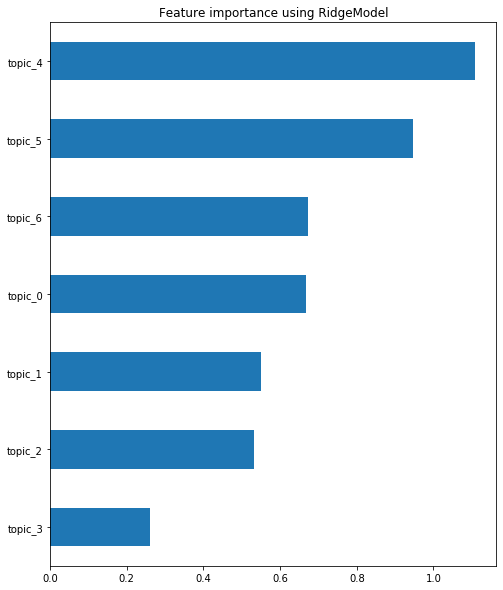

In [71]:
coef_ridge = pd.Series(ridge.coef_, index = X.columns)
imp_coef = coef_ridge.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using RidgeModel")

In [73]:
coef_ridge

topic_0    0.668716
topic_1    0.549885
topic_2    0.531446
topic_3    0.259741
topic_4    1.108882
topic_5    0.946356
topic_6    0.673564
dtype: float64

#### Lasso 

In [65]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)

/Users/jasper/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [66]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 0 variables


In [80]:
print('Lasso CV MSE:')
print(np.mean(reg.mse_path_))

Lasso CV MSE:
1.0830232388749617


Text(0.5, 1.0, 'Feature importance using Lasso Model')

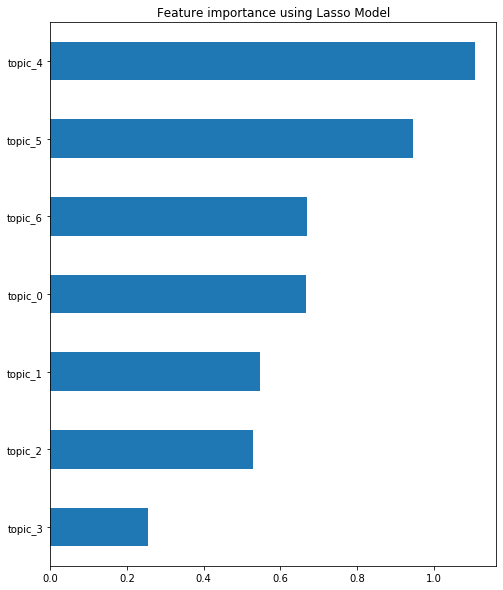

In [69]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [72]:
coef

topic_0    0.666412
topic_1    0.545871
topic_2    0.527879
topic_3    0.255754
topic_4    1.107129
topic_5    0.944273
topic_6    0.668980
dtype: float64

### Baseline algorithm test

- Use cross-validation to validate performance of different algorithms in totality

- Algorithms will be tested with different choices of parameters using GridSearchCV

  models       MSE
2  Ridge  1.034118
[{'normalize': True}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 0.1}]


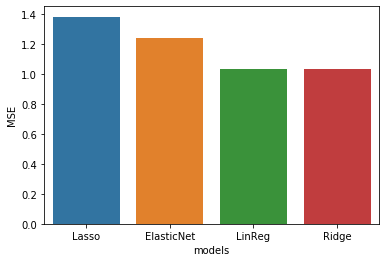

In [189]:
# GridSearch to see if optimizing the parameters will improve (lower) the MSE
reg_models = [('LinReg', LinearRegression(), {'normalize': [True, False]}),
              ('Lasso', Lasso(), {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}),
              ('Ridge', Ridge(), {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}),
              ('ElasticNet', ElasticNet(), {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}),
              ]


names = []
params = []
results = []

for name, model, param in reg_models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
    reg_grid = GridSearchCV(model, param, cv=kfold, scoring='neg_mean_squared_error')
    reg_grid.fit(X_train, y_train)
    best_model = reg_grid.best_estimator_
    names.append(name)
    params.append(reg_grid.best_params_)
    results.append(-reg_grid.best_score_)  # RMSE
    
    
result_df = pd.DataFrame({'models': names, 'results': results})
result_df.columns = ['models', 'MSE']
result_df.sort_values(by='MSE', ascending=False, inplace=True)
print(result_df.tail(1))
print(params)


sns.barplot(x='models', y='MSE', data=result_df);

In [1]:
# result_df

In [207]:
results

[1.0341205421479192,
 1.3836041092639086,
 1.0341176704437358,
 1.2432117394985278]

The best alpha level for ridge is 1 with the least mean square error among, 1.034.

### Finalise and validate model

In [199]:
model_lr = LinearRegression(normalize=True)
model_lr.fit(X_train, y_train)

# validation set
predictions = model_lr.predict(X_val)
MSE = mean_squared_error(y_val,predictions)
print(MSE)

1.087100782759048


In [200]:
SSE = MSE*len(y_val)
lr_test_aic = 5847*np.log(SSE/5847) + 2*7
lr_test_aic

-12957.907577474898

In [181]:
model_final = Ridge(alpha=1)
model_final.fit(X_train, y_train)

# validation set
predictions = model_final.predict(X_val)
MSE = mean_squared_error(y_val,predictions)
print(MSE)

1.086996129463049


In [182]:
X.shape

(5847, 7)

In [183]:
SSE = MSE*len(y_val)
ridge_test_aic = 5847*np.log(SSE/5847) + 2*7

In [184]:
ridge_test_aic

-12958.47048506079

*****

#### Forward Selection(OPTIONAL)

In [57]:
import statsmodels.formula.api as smf

# forward model selection evaluated by adjusted R-square
def forward_selected(data, response):
    
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [58]:
model = forward_selected(df_scores, 'stars')

print (model.model.formula)
print (model.rsquared_adj)

stars ~ topic_4 + topic_5 + topic_0 + topic_6 + topic_2 + topic_1 + topic_3 + userid + 1
0.267985499714121


In [59]:
df_scores_1 = df_scores.copy()

In [60]:
df_scores_1 = df_scores_1.drop(['topic_4'], axis=1)
model_1 = forward_selected(df_scores_1, 'stars')

print (model_1.model.formula)
print (model_1.rsquared_adj)

stars ~ topic_5 + topic_0 + topic_6 + topic_1 + topic_2 + topic_3 + userid + 1
0.2092832279232716
